# Imports

In [2]:
import tarfile
import os
import cv2
import imghdr
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [3]:
data_dir = r"C:\Users\Kush\MineD\data\test"
categories = ['BG', 'FACS', 'Macroscopy', 'Microscopy']


In [4]:
data_info = []

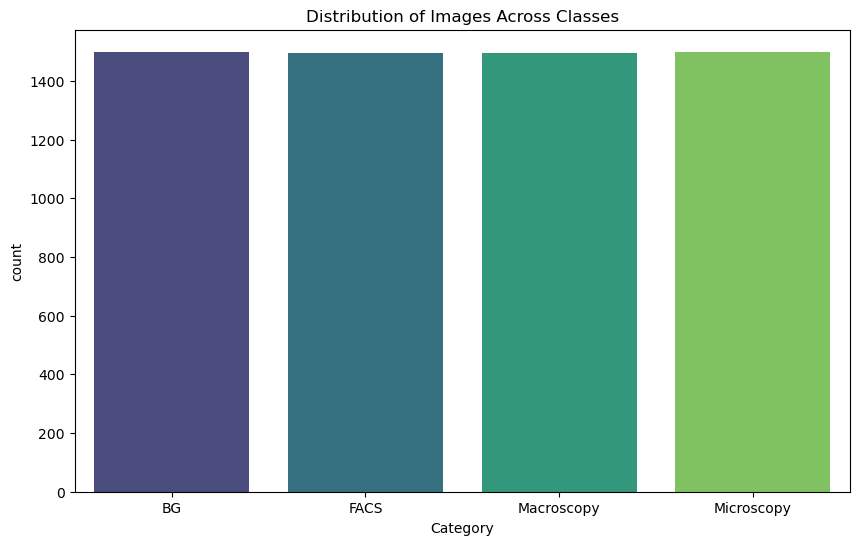

In [9]:
for category in categories:
    folder_path = os.path.join(data_dir, category)
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            file_path = os.path.join(folder_path, file_name)
            image = Image.open(file_path)
            width, height = image.size
            data_info.append([category, file_name, width, height])


df = pd.DataFrame(data_info, columns=['Category', 'File_Name', 'Width', 'Height'])
# Plot Distribution of Images Across Classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Category', palette='viridis')
plt.title('Distribution of Images Across Classes')
plt.show()


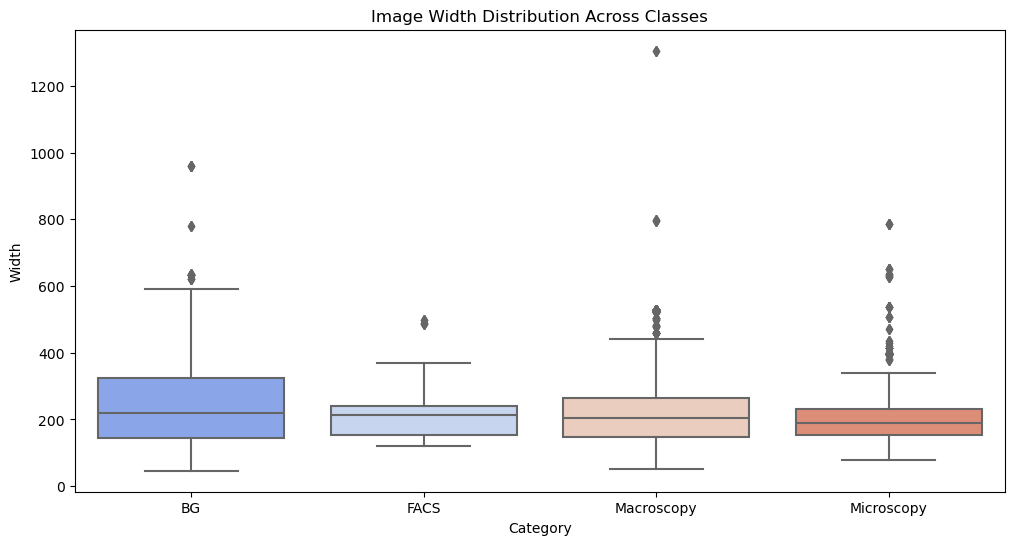

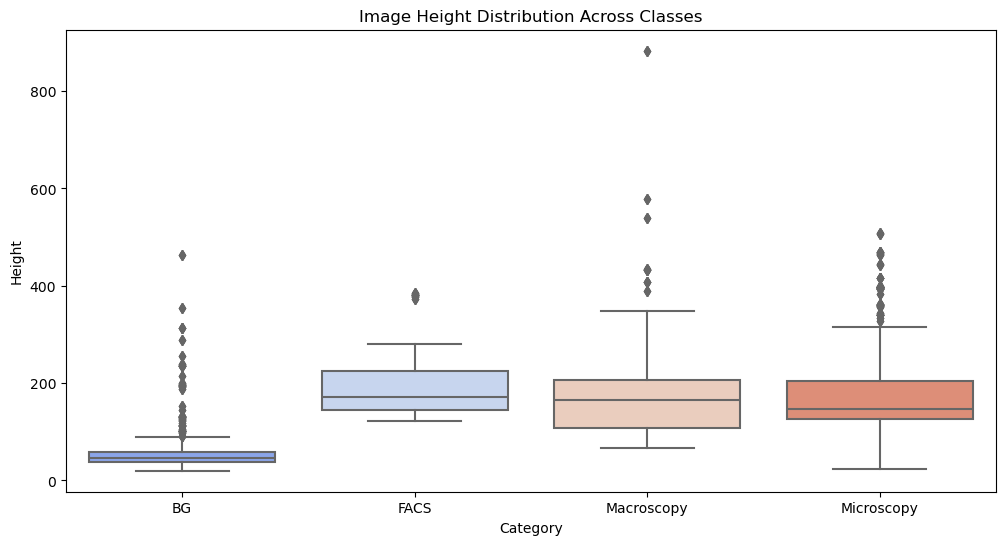

In [11]:
# Plot Image Dimensions
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Width', data=df, palette='coolwarm')
plt.title('Image Width Distribution Across Classes')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Height', data=df, palette='coolwarm')
plt.title('Image Height Distribution Across Classes')
plt.show()


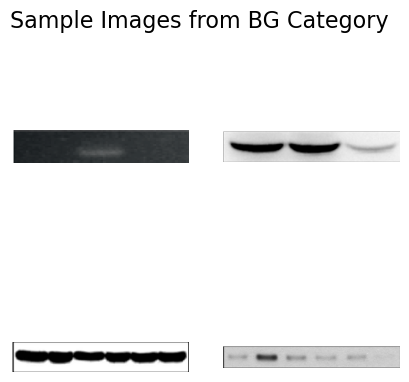

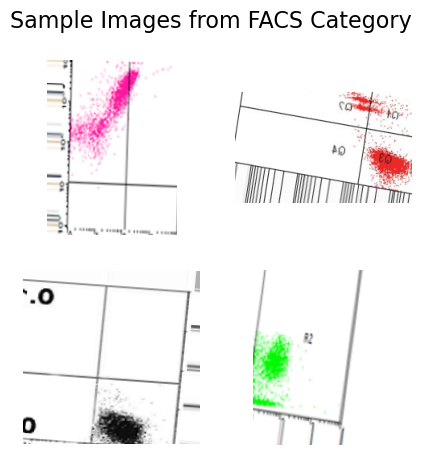

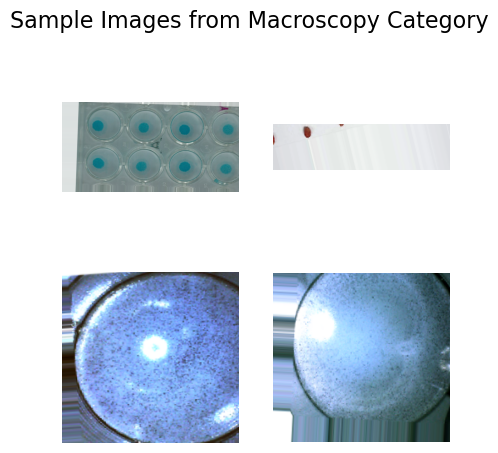

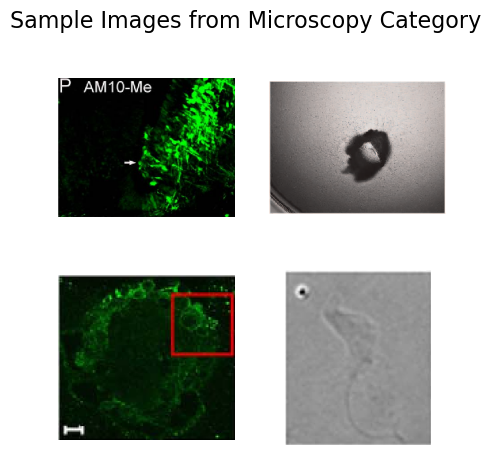

In [15]:
for category in categories:
    folder_path = os.path.join(data_dir, category)
    plt.figure(figsize=(5, 5))
    plt.suptitle(f'Sample Images from {category} Category', fontsize=16)
    
    sample_images = random.sample(os.listdir(folder_path), 4)
    
    for i, file_name in enumerate(sample_images):
        file_path = os.path.join(folder_path, file_name)
        img = io.imread(file_path)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()



In [16]:
# Basic Statistics
print("Basic Statistics of Image Width and Height per Category:")
print(df.groupby('Category').agg({'Width': ['mean', 'std'], 'Height': ['mean', 'std']}))

Basic Statistics of Image Width and Height per Category:
                 Width                  Height           
                  mean         std        mean        std
Category                                                 
BG          253.294000  142.568461   57.686000  46.528127
FACS        201.010020   62.387636  185.126253  47.139876
Macroscopy  236.695391  147.279894  175.987976  76.405493
Microscopy  208.474000   98.045816  176.074000  83.031757


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os


In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for label in os.listdir(root_dir):
            label_folder = os.path.join(root_dir, label)
            if os.path.isdir(label_folder):
                for img_name in os.listdir(label_folder):
                    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):  # Handle multiple extensions
                        self.image_paths.append(os.path.join(label_folder, img_name))
                        self.labels.append(label)
        
        if not self.image_paths:
            raise ValueError("No images found in the specified directory.")
        
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_name = self.labels[idx]
        label = self.label_to_idx[label_name]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [8]:
# Load the dataset
full_dataset = CustomDataset(root_dir=r'data\test', transform=transform)

# Perform train-validation split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


In [9]:
print(f"Total number of images: {len(full_dataset)}")


Total number of images: 1998


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms


In [12]:
# Load EfficientNetB3 with pre-trained weights
model = models.efficientnet_b3(pretrained=True)

# Modify the classifier to fit your number of classes
num_classes = len(full_dataset.label_to_idx)  # Number of output classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)


C:\Users\Kush\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kush\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [15]:
model = models.efficientnet_b3(pretrained=True)
num_classes = len(full_dataset.label_to_idx)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")


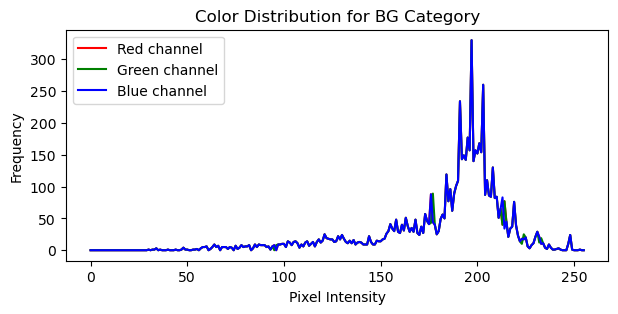

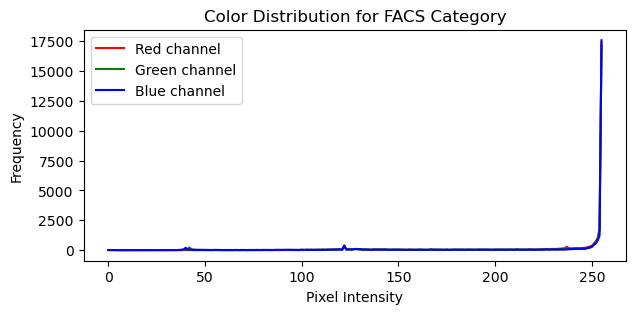

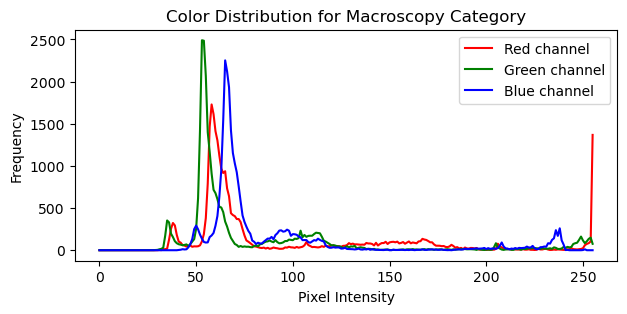

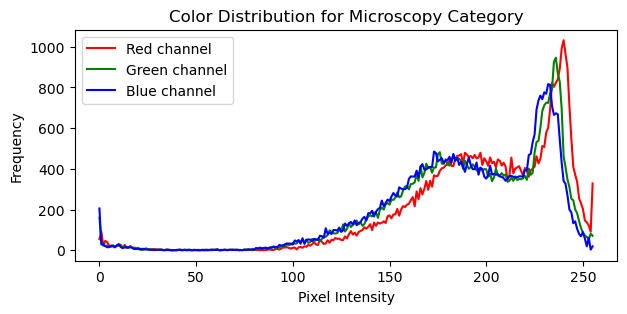

In [19]:
# Color Distribution Analysis
def plot_color_distribution(image_path, title):
    image = io.imread(image_path)
    plt.figure(figsize=(7, 3))
    
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        histo, _ = np.histogram(image[:, :, i], bins=256, range=(0, 256))
        plt.plot(histo, color=color.lower(), label=f'{color} channel')
    
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


for category in categories:
    folder_path = os.path.join(data_dir, category)
    sample_image = random.choice(os.listdir(folder_path))
    sample_image_path = os.path.join(folder_path, sample_image)
    plot_color_distribution(sample_image_path, f'Color Distribution for {category} Category')


# Load The Data

In [4]:
img = cv2.imread(os.path.join(r"C:\Users\Kush\MineD\data\Split_data_final\BG\010000.png_392.png"))

In [5]:
img.shape

(38, 208, 3)

In [6]:
from matplotlib import pyplot as plt

In [7]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224,224))

Found 111668 files belonging to 5 classes.


In [8]:
len(data)

3490

In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()
batch[0].shape

(32, 224, 224, 3)

In [11]:
len(batch)

2

In [12]:
len(batch[0])

32

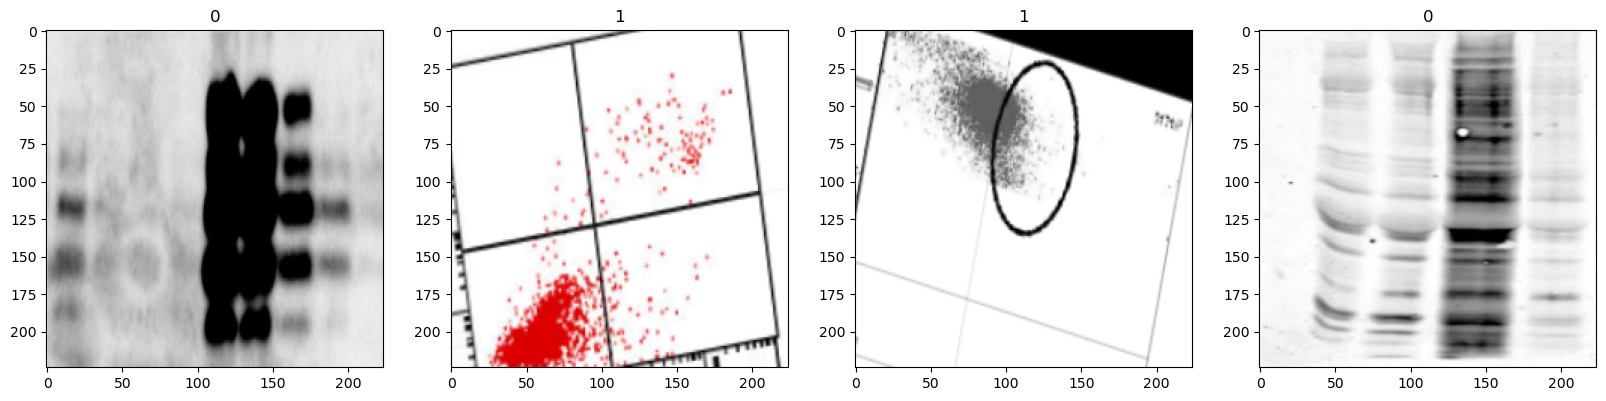

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
data = data.map(lambda x,y: (x/224.,y))

In [15]:
scaled_iterator = data.as_numpy_iterator()

In [16]:
batch = scaled_iterator.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


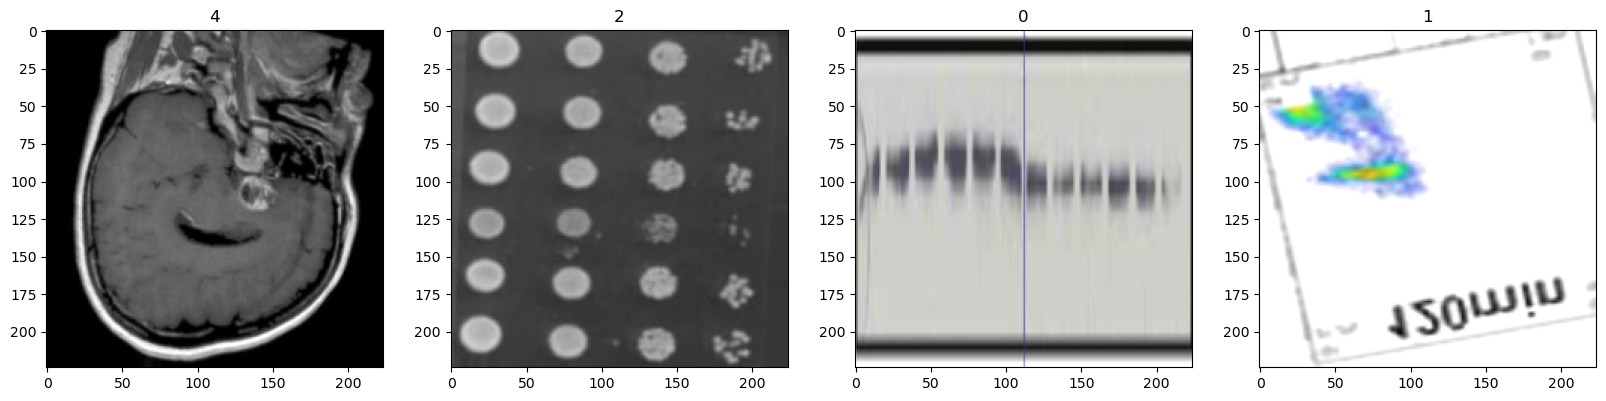

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [18]:
len(data)

3490

In [19]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1


In [20]:
train_size + val_size + test_size

3492

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [2]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

In [50]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze the base model layers


In [51]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [52]:
model = Model(inputs=base_model.input, outputs=output)

In [53]:
# Compile the model using sparse categorical crossentropy
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [54]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_3[0][0]'

                                                                                                  
 block2a_expand_conv (Conv2  (None, 112, 112, 144)        3456      ['block1b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2a_expand_bn (BatchNo  (None, 112, 112, 144)        576       ['block2a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2a_expand_activation   (None, 112, 112, 144)        0         ['block2a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2a_d

 block2c_expand_conv (Conv2  (None, 56, 56, 192)          6144      ['block2b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2c_expand_bn (BatchNo  (None, 56, 56, 192)          768       ['block2c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2c_expand_activation   (None, 56, 56, 192)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_dwconv (DepthwiseC  (None, 56, 56, 192)          1728      ['block2c_expand_activation[0]
 onv2D)   

 D)                                                                                               
                                                                                                  
 block3b_expand_bn (BatchNo  (None, 28, 28, 288)          1152      ['block3b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block3b_expand_activation   (None, 28, 28, 288)          0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_dwconv (DepthwiseC  (None, 28, 28, 288)          7200      ['block3b_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4a_expand_conv (Conv2  (None, 28, 28, 288)          13824     ['block3c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4a_expand_bn (BatchNo  (None, 28, 28, 288)          1152      ['block4a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4a_expand_activation   (None, 28, 28, 288)          0         ['block4a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4a_dwconv_pad (ZeroPa  (None, 29, 29, 288)          0         ['block4a_expand_activation[0]
 dding2D) 

 D)                                                                                               
                                                                                                  
 block4c_expand_bn (BatchNo  (None, 14, 14, 576)          2304      ['block4c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4c_expand_activation   (None, 14, 14, 576)          0         ['block4c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4c_dwconv (DepthwiseC  (None, 14, 14, 576)          5184      ['block4c_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4e_expand_conv (Conv2  (None, 14, 14, 576)          55296     ['block4d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4e_expand_bn (BatchNo  (None, 14, 14, 576)          2304      ['block4e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4e_expand_activation   (None, 14, 14, 576)          0         ['block4e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4e_dwconv (DepthwiseC  (None, 14, 14, 576)          5184      ['block4e_expand_activation[0]
 onv2D)   

 rmalization)                                                                                     
                                                                                                  
 block5b_expand_activation   (None, 14, 14, 816)          0         ['block5b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5b_dwconv (DepthwiseC  (None, 14, 14, 816)          20400     ['block5b_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5b_bn (BatchNormaliza  (None, 14, 14, 816)          3264      ['block5b_dwconv[0][0]']      
 tion)                                                                                            
          

 block5d_expand_bn (BatchNo  (None, 14, 14, 816)          3264      ['block5d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5d_expand_activation   (None, 14, 14, 816)          0         ['block5d_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5d_dwconv (DepthwiseC  (None, 14, 14, 816)          20400     ['block5d_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5d_bn (BatchNormaliza  (None, 14, 14, 816)          3264      ['block5d_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6a_expand_bn (BatchNo  (None, 14, 14, 816)          3264      ['block6a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6a_expand_activation   (None, 14, 14, 816)          0         ['block6a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6a_dwconv_pad (ZeroPa  (None, 17, 17, 816)          0         ['block6a_expand_activation[0]
 dding2D)                                                           [0]']                         
                                                                                                  
 block6a_d

 block6c_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_expand_activation   (None, 7, 7, 1392)           0         ['block6c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6c_dwconv (DepthwiseC  (None, 7, 7, 1392)           34800     ['block6c_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6c_bn (BatchNormaliza  (None, 7, 7, 1392)           5568      ['block6c_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6e_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6e_expand_activation   (None, 7, 7, 1392)           0         ['block6e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6e_dwconv (DepthwiseC  (None, 7, 7, 1392)           34800     ['block6e_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6e_b

 D)                                                                                               
                                                                                                  
 block7a_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block7a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block7a_expand_activation   (None, 7, 7, 1392)           0         ['block7a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block7a_dwconv (DepthwiseC  (None, 7, 7, 1392)           12528     ['block7a_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 top_activation (Activation  (None, 7, 7, 1536)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d_3  (None, 1536)                 0         ['top_activation[0][0]']      
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 dense_3 (Dense)             (None, 5)                    7685      ['global_average_pooling2d_3[0
                                                                    ][0]']                        
                                                                                                  
Total params: 10791220 (41.17 MB)
Trainable params: 7685 (30.02 KB)
Non-trainable params: 10783535 (41.14 MB)

In [ ]:
hist = model.fit(train, epochs=(3), validation_data=val)

Epoch 1/3
  45/2443 [..............................] - ETA: 1:21:36 - loss: 1.5731 - accuracy: 0.3292

In [3]:
print(tf.config.list_physical_devices('GPU'))


[]


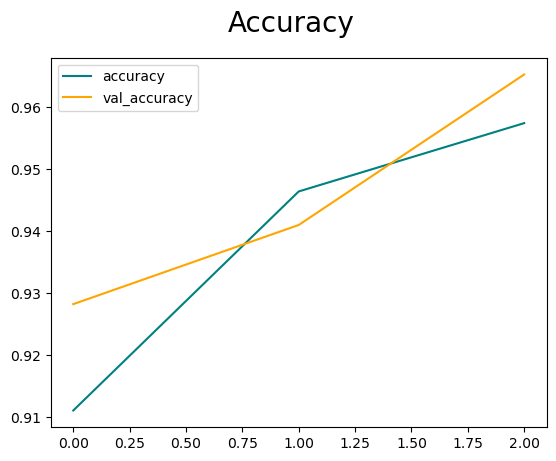

In [101]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


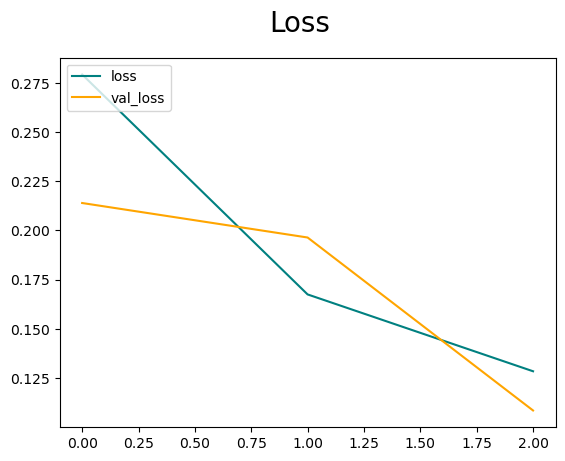

In [102]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [90]:
from tensorflow.keras.models import load_model
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

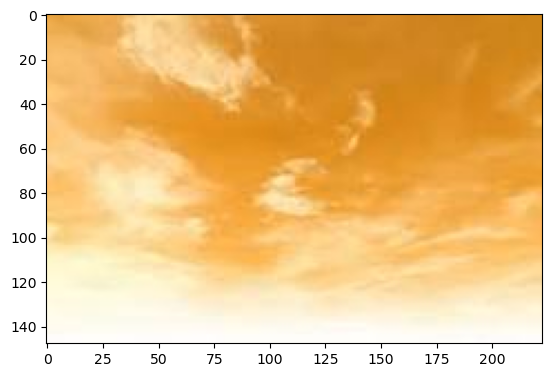

In [97]:
img = cv2.imread(r"C:\Users\Kush\Downloads\download (3).jpeg")
plt.imshow(img)
plt.show()

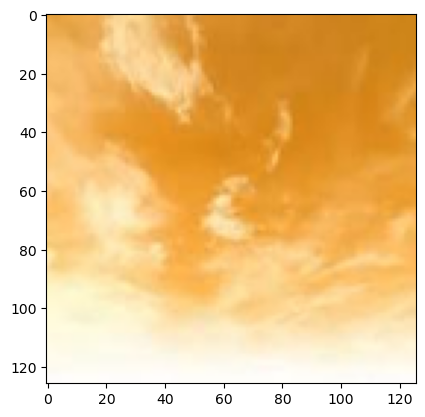

In [98]:
resize = tf.image.resize(img, (126,126))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [99]:
yhat = model.predict(np.expand_dims(resize/126, 0))

1/1 [==============================] - 0s 33ms/step


In [104]:
yhat*10**9

array([[1.15599692e+08, 1.03026992e+07, 3.92867714e+08, 4.81229842e+08]])

In [60]:

for c_label in os.listdir(r"C:\Users\Kush\MineD\data\Split_data_final"):
    print(c_label)

BG
FACS
Macroscopy
Microscopy
None of the above
